This approach uses an advanced text mining method, Latent Dirichlet allocation (LDA).

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline 

Root Mean Squared Logarithmic Error (RMSLE) as the evaluation metrics

In [2]:
def rmsle(y, y_pred):
    """
    A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
    """
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

Load the dataset

In [3]:
data = pd.read_table("train.tsv")
display(data.head(n=3))
print(data.shape)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,100000,3 piece crop top/halter set,3,Women/Tops & Blouses/Halter,FOREVER 21,19.0,0,All size small
1,100001,Fitbit Alta Bundle for Nathalia Lopez,1,Sports & Outdoors/Exercise/Fitness accessories,Fitbit,12.0,0,Fitbit Alta replacement bands - 5 colors for N...
2,100002,iPad Gen 2 / Verizon,4,Electronics/Computers & Tablets/iPad/Tablet/eB...,Apple,56.0,0,iPad Gen 2 with Verizon cell abilities. The wi...


(100001, 8)


## Data Preprocessing
Show distribution of price

Text(0.5,0,'Price')

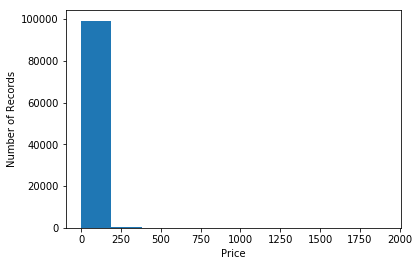

In [4]:
plt.hist(data['price'], normed=False, bins=10)
plt.ylabel('Number of Records');
plt.xlabel('Price')

Log-transfer and normalize price

Text(0.5,0,'Target (Log-transformed and normalized Price)')

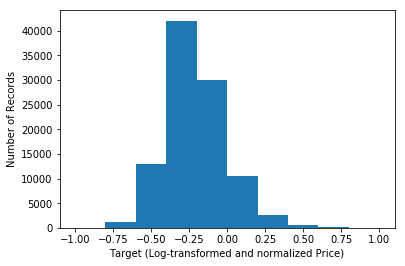

In [5]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

data['target'] = np.log(data['price']+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
data["target"] = target_scaler.fit_transform(data.target.values.reshape(-1,1))

plt.hist(data['target'], normed=False, bins=10)
plt.ylabel('Number of Records')
plt.xlabel('Target (Log-transformed and normalized Price)')

In [6]:
print('Number of different brand names is {}.'.format(data['brand_name'].value_counts().size))
print('Number of different categories is {}.'.format(data['category_name'].value_counts().size))

Number of different brand names is 2072.
Number of different categories is 972.


- Handle missing data;
- Cut number of brand names and number of categories;
- Transfer category_name, brand_name, and item_condition_id to categorical data.

In [7]:
NUM_BRANDS = 1000
NUM_CATEGORIES = 1000

def handle_missing_inplace(dataset):
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)

def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    dataset.loc[~dataset['category_name'].isin(pop_category), 'category_name'] = 'missing'


def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

handle_missing_inplace(data)
print('Finished to handle missing')

cutting(data)
print('Finished to cut')

to_categorical(data)
print('Finished to convert categorical')

Finished to handle missing
Finished to cut
Finished to convert categorical


- Count vectorize category_name and  brand_name.
- Transfer item_condition_id and shipping to dummy variables.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer

cv = CountVectorizer()
X_category = cv.fit_transform(data['category_name'])
print('Finished count vectorize `category_name`')
#%%
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(data['brand_name'])
print('Finished label binarize `brand_name`')
#%%
X_dummies = pd.get_dummies(data[['item_condition_id', 'shipping']],
                                          sparse=True)
print('Finished to get dummies on `item_condition_id` and `shipping`')

Finished count vectorize `category_name`
Finished label binarize `brand_name`
Finished to get dummies on `item_condition_id` and `shipping`


## PROCESS TEXT: RAW

In [9]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

sw = set(stopwords.words('english')+
         ['eing','oing','aing','uing','aed','eed',
         'would','always', 'food', 'good','great', 'us', 'b','like',
         'amp', 'go','place']) # stopwords

def text_process(text,sw):
    review_temp = text
    review_temp = review_temp.strip() # remove \n at the end.
    review_temp = re.sub('[^a-zA-Z]', ' ', review_temp)
    review_temp = review_temp.split()
    ps = PorterStemmer()
    review_temp = [ps.stem(word) for word in review_temp 
                   if not word in sw]
    return review_temp   

raw_text = np.hstack([data.item_description.str.lower(), data.name.str.lower()])
corpus = [text_process(text,sw) for text in raw_text]

Remove terms that appear less than 5 times.

In [10]:
from collections import defaultdict
frequency = defaultdict(int)
for text in corpus:
    for token in text:
        frequency[token] += 1
corpus = [[token for token in text if frequency[token] > 5]
         for text in corpus]

- Generate dictionary and term-document matrix.
- They are saved in the **approach1_output** folder.

In [11]:
from gensim import corpora
dictionary = corpora.Dictionary(documents=corpus, prune_at=2000)
#dictionary.save('approach1_output/dictionary.dict')  # store the dictionary, for future reference
corpusVector = [dictionary.doc2bow(text) for text in corpus]
#corpora.MmCorpus.serialize('approach1_output/corpusVector.mm', corpusVector)

C:\Users\zhipe\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [12]:
print(corpusVector[:3])
print("Number of terms in dictionary is {}".format(len(dictionary)))

[[(0, 1), (1, 1)], [(2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1)]]
Number of terms in dictionary is 2000


Apply LDA method to extract 100 topics from the texts. 

In [13]:
from gensim import models
lda = models.ldamodel.LdaModel(corpus=corpusVector, id2word=dictionary, 
                               num_topics=100, update_every=1, 
                               chunksize=2000, passes=1,
                               minimum_probability=0.0001,random_state=666)

C:\Users\zhipe\Anaconda3\envs\tensorflow\lib\site-packages\gensim\models\ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Show the first 5 topics. 

In [14]:
lda.print_topics(5)

[(7,
  '0.313*"xs" + 0.149*"size" + 0.133*"fit" + 0.112*"booti" + 0.088*"wedg" + 0.077*"true" + 0.027*"bnib" + 0.025*"ruffl" + 0.020*"child" + 0.017*"mid"'),
 (57,
  '0.159*"lipstick" + 0.153*"kit" + 0.120*"kyli" + 0.105*"matt" + 0.076*"liquid" + 0.048*"nude" + 0.045*"patch" + 0.042*"candi" + 0.040*"holiday" + 0.034*"crochet"'),
 (20,
  '0.481*"xl" + 0.338*"new" + 0.068*"brand" + 0.019*"halloween" + 0.016*"spray" + 0.015*"harley" + 0.012*"size" + 0.010*"batman" + 0.010*"bombshel" + 0.009*"xxl"'),
 (46,
  '0.546*"sweatshirt" + 0.097*"foam" + 0.079*"overal" + 0.058*"fix" + 0.051*"machin" + 0.050*"memori" + 0.031*"intens" + 0.024*"close" + 0.016*"flap" + 0.007*"size"'),
 (32,
  '0.463*"tart" + 0.125*"state" + 0.123*"planner" + 0.102*"melt" + 0.048*"tube" + 0.028*"semi" + 0.022*"almost" + 0.019*"pill" + 0.017*"fade" + 0.010*"background"')]

Save the lda model. 

In [15]:
lda.save('model.lda') # same for tfidf, lda, ...
f = open('lda_topics.csv','w')
topic_list = lda.print_topics(-1)
for topic in topic_list:
    f.write(str(topic[0])+',' + ','.join(topic[1].replace('*','+').split('+')) + '\n')
f.close()

- Create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi
- The LDA scores for each text are the topic distributions in this text. 
- The LDA scores for item_description and name are generated.

In [16]:
corpus_lda = lda[corpusVector]
lda_scores = pd.DataFrame([[topic[1] for topic in doc] 
                                        if doc != [] else [0,0] 
                                        for doc in corpus_lda])
print(lda_scores.shape)
nproducts = data.shape[0]
lda_item_description = lda_scores.iloc[:nproducts,]
lda_name = lda_scores.iloc[nproducts:,]

(200002, 100)


Handle nan values in lda_item_description and lda_name.

In [17]:
lda_item_description[np.isnan(lda_item_description)] = 0
lda_name[np.isnan(lda_name)] = 0

C:\Users\zhipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\zhipe\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:2554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
C:\Users\zhipe\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Combine variables into x (input) and y (output).

In [18]:
from scipy.sparse import csr_matrix, hstack
x = hstack((X_category, X_brand,X_dummies,lda_item_description,lda_name)).tocsr()
y = data["target"]

Splite data.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, 
                                                    random_state=99)

X_dtrain, X_dvalid, y_dtrain, y_dvalid = train_test_split(X_train, y_train, test_size=0.01, 
                                                    random_state=99)
print(X_dtrain.shape)
print(X_dvalid.shape)

(89100, 2079)
(900, 2079)


# Deep Learning
- KERAS DATA DEFINITION

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import backend as K

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1

    model = Sequential()
    model.add(Dense(units = 128, activation = 'relu', input_dim = X_dtrain.shape[1]))
    model.add(Dropout(dr_r))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dropout(dr_r))
    model.add(Dense(units = 1,  activation = 'linear'))        

    model.compile(loss="mse", optimizer="rmsprop", metrics=["mae", rmsle_cust])
    
    return model
    
model = get_model()
model.summary()

C:\Users\zhipe\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               266240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 274,561
Trainable params: 274,561
Non-trainable params: 0
_________________________________________________________________


Fitting the model.

In [21]:
BATCH_SIZE = 3000
epochs = 5

history = model.fit(X_dtrain, y_dtrain, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_dvalid, y_dvalid)
          , verbose=1)

Train on 89100 samples, validate on 900 samples
Epoch 1/5
89100/89100 [==============================] - 6s 66us/step - loss: 0.0318 - mean_absolute_error: 0.1368 - rmsle_cust: 0.0179 - val_loss: 0.0220 - val_mean_absolute_error: 0.1121 - val_rmsle_cust: 0.0133
Epoch 2/5
89100/89100 [==============================] - 2s 27us/step - loss: 0.0241 - mean_absolute_error: 0.1186 - rmsle_cust: 0.0157 - val_loss: 0.0205 - val_mean_absolute_error: 0.1087 - val_rmsle_cust: 0.0126
Epoch 3/5
89100/89100 [==============================] - 2s 27us/step - loss: 0.0226 - mean_absolute_error: 0.1147 - rmsle_cust: 0.0152 - val_loss: 0.0205 - val_mean_absolute_error: 0.1076 - val_rmsle_cust: 0.0123
Epoch 4/5
89100/89100 [==============================] - 2s 27us/step - loss: 0.0217 - mean_absolute_error: 0.1120 - rmsle_cust: 0.0149 - val_loss: 0.0220 - val_mean_absolute_error: 0.1149 - val_rmsle_cust: 0.0129
Epoch 5/5
89100/89100 [==============================] - 2s 27us/step - loss: 0.0210 - mean_abso

Evaluate the model using validation data.

In [23]:
print(y_test[:6])

86156    0.338541
29633   -0.365204
67710   -0.418328
62348   -0.147866
79452    0.645724
66334   -0.342170
Name: target, dtype: float64


In [24]:
y_pred = model.predict(X_dvalid)
y_pred = target_scaler.inverse_transform(y_pred)
y_pred = np.expm1(y_pred)
y_true = target_scaler.inverse_transform(y_dvalid[:,np.newaxis])
y_true = np.expm1(y_true)
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on validation dataset: "+str(v_rmsle))

 RMSLE error on validation dataset: 0.5834955409768858


Evaluate the model using test data.

In [25]:
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)
y_pred = np.expm1(y_pred)
y_true = target_scaler.inverse_transform(y_test[:,np.newaxis])
y_true = np.expm1(y_true)
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on test dataset: "+str(v_rmsle))

 RMSLE error on test dataset: 0.5682737195113022


Save model